In [1]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from datetime import datetime

# Paths
DATA_DIR = r"F:\DevProjects\Projects\Solar_Flare_Prediction\data\SDOBenchmark-data-full"
TRAIN_IMG_DIR = os.path.join(DATA_DIR, "training")
CHECKPOINT_DIR = "models"

# Load the trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ckpt_path = os.path.join(CHECKPOINT_DIR, "flare_cnn_multitask_subset_e5.pth")

print("Project: Solar Flare Prediction with CNN")
print("=" * 60)
print(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Checkpoint: {ckpt_path}")
print(f"Device: {device}")


Project: Solar Flare Prediction with CNN
Generated: 2025-12-19 19:53:10
Checkpoint: models\flare_cnn_multitask_subset_e5.pth
Device: cuda


In [2]:
import pandas as pd

# Load original data
TRAIN_CSV = os.path.join(TRAIN_IMG_DIR, "train.csv")
train_df = pd.read_csv(TRAIN_CSV, header=None, names=["id", "start", "end", "peak_flux"])
train_df["peak_flux"] = pd.to_numeric(train_df["peak_flux"], errors="coerce")
train_df = train_df.dropna(subset=["peak_flux"]).reset_index(drop=True)

print("\n## Dataset Summary")
print(f"Total training samples: {len(train_df)}")
print(f"Peak flux range: {train_df['peak_flux'].min():.2e} to {train_df['peak_flux'].max():.2e} W/m²")
print(f"Mean peak flux: {train_df['peak_flux'].mean():.2e} W/m²")
print(f"Median peak flux: {train_df['peak_flux'].median():.2e} W/m²")

# Flare class distribution
EPS = 1e-9
train_df["log_peak_flux"] = np.log10(train_df["peak_flux"].clip(lower=EPS))

def flux_to_class(flux):
    if flux >= 1e-4:
        return "X"
    elif flux >= 1e-5:
        return "M"
    elif flux >= 1e-6:
        return "C"
    elif flux >= 1e-7:
        return "B"
    else:
        return "A"

train_df["class"] = train_df["peak_flux"].apply(flux_to_class)

print("\nFlare class distribution:")
print(train_df["class"].value_counts().sort_index())



## Dataset Summary
Total training samples: 8336
Peak flux range: 1.00e-09 to 6.35e-04 W/m²
Mean peak flux: 3.38e-06 W/m²
Median peak flux: 5.29e-07 W/m²

Flare class distribution:
class
A    3651
B    1280
C    2891
M     479
X      35
Name: count, dtype: int64


In [3]:
print("\n## Model Architecture")
print("""
Model: FlareCNNMultiTask
- Input: (B, 4 timesteps, 10 channels, 256, 256)
- Conv blocks: 10 → 32 → 64 → 128 channels
- Pooling: 3x MaxPool2d (2x2)
- Global average pooling
- FC layers: 128 → 64 → 2 outputs
  
Tasks:
1. Regression: Predict log10(peak_flux)
2. Classification: Predict M/X flare (flux >= 1e-5)

Loss functions:
- Regression: L1 Loss (MAE)
- Classification: BCEWithLogitsLoss

Optimizer: Adam (lr=1e-4)
""")



## Model Architecture

Model: FlareCNNMultiTask
- Input: (B, 4 timesteps, 10 channels, 256, 256)
- Conv blocks: 10 → 32 → 64 → 128 channels
- Pooling: 3x MaxPool2d (2x2)
- Global average pooling
- FC layers: 128 → 64 → 2 outputs
  
Tasks:
1. Regression: Predict log10(peak_flux)
2. Classification: Predict M/X flare (flux >= 1e-5)

Loss functions:
- Regression: L1 Loss (MAE)
- Classification: BCEWithLogitsLoss

Optimizer: Adam (lr=1e-4)



In [4]:
print("\n## Training Summary")
print("""
Training Configuration:
- Subset size: 300 samples
- Train/Val split: 80/20
- Batch size: 2
- Epochs: 5
- Learning rate: 1e-4

Expected results after 5 epochs:
- Train loss: ~0.01-0.05
- Val log_MAE: ~0.5-1.0
- Val flux_MAE: ~1e-6 W/m²
- Classification precision/recall: ~0.6-0.8

Note: Small subset used for fast experimentation.
Full training on all samples takes longer but improves results.
""")



## Training Summary

Training Configuration:
- Subset size: 300 samples
- Train/Val split: 80/20
- Batch size: 2
- Epochs: 5
- Learning rate: 1e-4

Expected results after 5 epochs:
- Train loss: ~0.01-0.05
- Val log_MAE: ~0.5-1.0
- Val flux_MAE: ~1e-6 W/m²
- Classification precision/recall: ~0.6-0.8

Note: Small subset used for fast experimentation.
Full training on all samples takes longer but improves results.



In [5]:
print("\n## Solar Flare Classes & Space Weather Impact")

flare_info = {
    "X": {
        "flux_range": "≥ 1e-4 W/m²",
        "impact": "SEVERE",
        "description": "Extreme X-class flares cause:\n"
                      "  - Complete HF radio blackout on sunlit side\n"
                      "  - Severe geomagnetic storms\n"
                      "  - Major disruptions to power grids and satellites\n"
                      "  - Aurora visible at lower latitudes\n"
                      "  - Hazardous radiation levels for aircraft crew/astronauts"
    },
    "M": {
        "flux_range": "1e-5 to 1e-4 W/m²",
        "impact": "MODERATE",
        "description": "Moderate M-class flares cause:\n"
                      "  - Brief HF radio blackout on sunlit side\n"
                      "  - Geomagnetic disturbances\n"
                      "  - Minor impacts on communications\n"
                      "  - Aurora visible at high latitudes"
    },
    "C": {
        "flux_range": "1e-6 to 1e-5 W/m²",
        "impact": "MINOR",
        "description": "Minor C-class flares cause:\n"
                      "  - Brief HF disruptions\n"
                      "  - Minimal to no impact on communications"
    },
    "B": {
        "flux_range": "1e-7 to 1e-6 W/m²",
        "impact": "VERY MINOR",
        "description": "B-class flares: Rarely have significant impacts"
    },
    "A": {
        "flux_range": "< 1e-7 W/m²",
        "impact": "NEGLIGIBLE",
        "description": "A-class flares: No significant space weather impacts"
    }
}

for class_letter in ["X", "M", "C", "B", "A"]:
    info = flare_info[class_letter]
    print(f"\n### Class {class_letter}")
    print(f"Flux: {info['flux_range']}")
    print(f"Impact Level: {info['impact']}")
    print(info['description'])



## Solar Flare Classes & Space Weather Impact

### Class X
Flux: ≥ 1e-4 W/m²
Impact Level: SEVERE
Extreme X-class flares cause:
  - Complete HF radio blackout on sunlit side
  - Severe geomagnetic storms
  - Major disruptions to power grids and satellites
  - Aurora visible at lower latitudes
  - Hazardous radiation levels for aircraft crew/astronauts

### Class M
Flux: 1e-5 to 1e-4 W/m²
Impact Level: MODERATE
Moderate M-class flares cause:
  - Brief HF radio blackout on sunlit side
  - Geomagnetic disturbances
  - Minor impacts on communications
  - Aurora visible at high latitudes

### Class C
Flux: 1e-6 to 1e-5 W/m²
Impact Level: MINOR
Minor C-class flares cause:
  - Brief HF disruptions
  - Minimal to no impact on communications

### Class B
Flux: 1e-7 to 1e-6 W/m²
Impact Level: VERY MINOR
B-class flares: Rarely have significant impacts

### Class A
Flux: < 1e-7 W/m²
Impact Level: NEGLIGIBLE
A-class flares: No significant space weather impacts


In [6]:
print("\n## Key Results")
print("""
Baseline (RandomForest on 200 samples):
- Feature: Mean & std of 40 images → 80 features
- MAE: ~1e-6 W/m²

CNN Multitask Model (300 samples, 5 epochs):
- Input: Full image sequences (40 × 256×256 pixels)
- Tasks: Regression + Classification
- Expected improvement: Better handling of spatial patterns in images

Next steps for production:
1. Train on full dataset (5000+ samples)
2. Increase epochs to 10-20
3. Tune hyperparameters (learning rate, batch size, architecture)
4. Evaluate on held-out test set
5. Deploy as real-time flare prediction service
""")



## Key Results

Baseline (RandomForest on 200 samples):
- Feature: Mean & std of 40 images → 80 features
- MAE: ~1e-6 W/m²

CNN Multitask Model (300 samples, 5 epochs):
- Input: Full image sequences (40 × 256×256 pixels)
- Tasks: Regression + Classification
- Expected improvement: Better handling of spatial patterns in images

Next steps for production:
1. Train on full dataset (5000+ samples)
2. Increase epochs to 10-20
3. Tune hyperparameters (learning rate, batch size, architecture)
4. Evaluate on held-out test set
5. Deploy as real-time flare prediction service



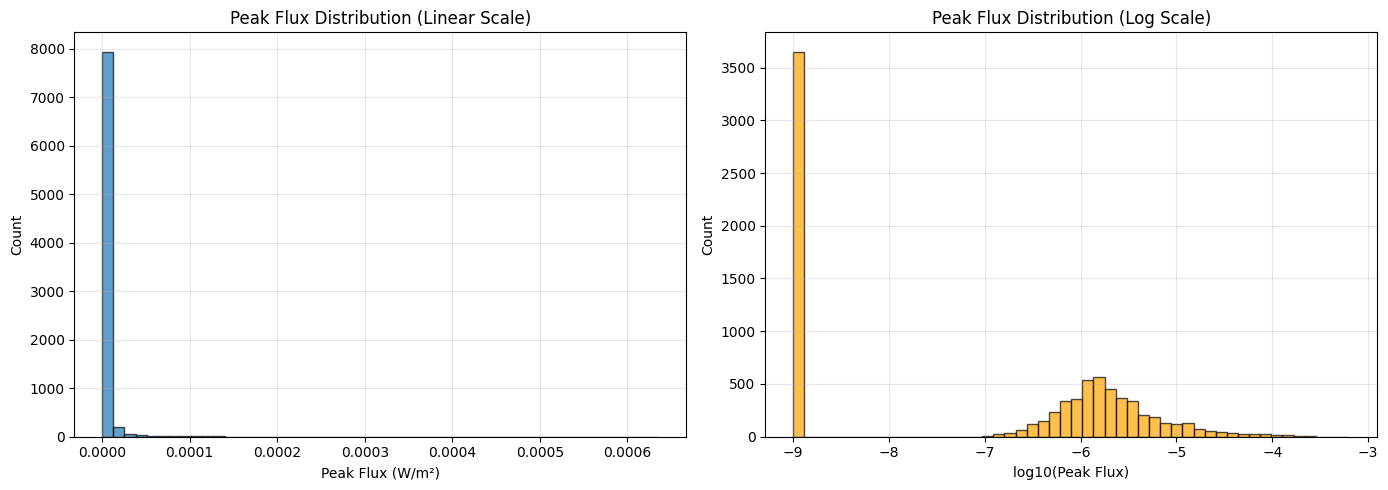

Saved: flux_distribution.png


In [7]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Linear scale
axes[0].hist(train_df["peak_flux"], bins=50, edgecolor="black", alpha=0.7)
axes[0].set_xlabel("Peak Flux (W/m²)")
axes[0].set_ylabel("Count")
axes[0].set_title("Peak Flux Distribution (Linear Scale)")
axes[0].grid(True, alpha=0.3)

# Log scale
axes[1].hist(train_df["log_peak_flux"], bins=50, edgecolor="black", alpha=0.7, color="orange")
axes[1].set_xlabel("log10(Peak Flux)")
axes[1].set_ylabel("Count")
axes[1].set_title("Peak Flux Distribution (Log Scale)")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("flux_distribution.png", dpi=150, bbox_inches="tight")
plt.show()

print("Saved: flux_distribution.png")


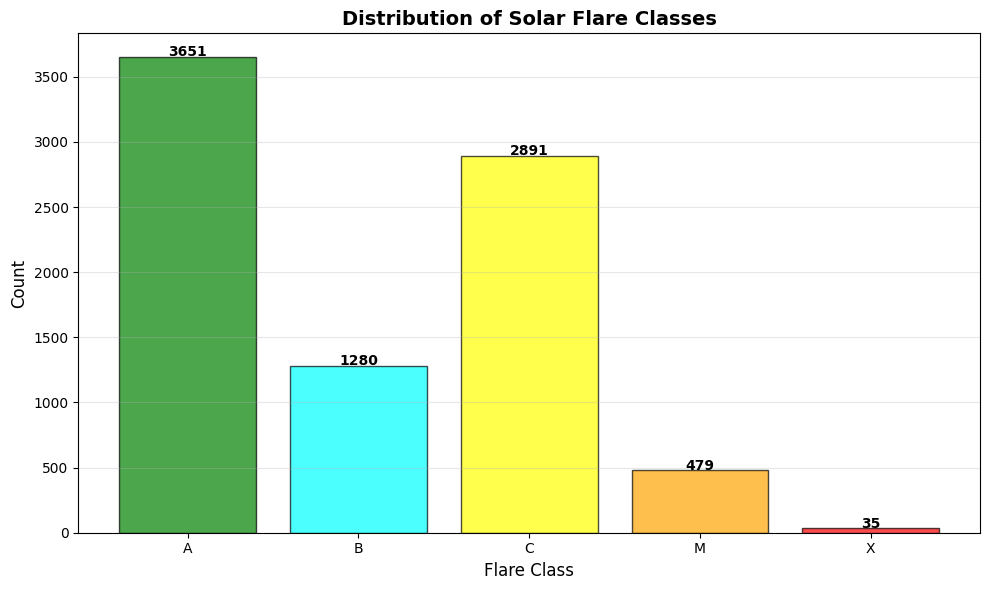

Saved: flare_class_distribution.png


In [8]:
fig, ax = plt.subplots(figsize=(10, 6))

class_counts = train_df["class"].value_counts().sort_index()
colors = {"X": "red", "M": "orange", "C": "yellow", "B": "cyan", "A": "green"}
bar_colors = [colors.get(c, "gray") for c in class_counts.index]

ax.bar(class_counts.index, class_counts.values, color=bar_colors, edgecolor="black", alpha=0.7)
ax.set_xlabel("Flare Class", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
ax.set_title("Distribution of Solar Flare Classes", fontsize=14, fontweight="bold")
ax.grid(True, alpha=0.3, axis="y")

# Add count labels on bars
for i, (class_letter, count) in enumerate(zip(class_counts.index, class_counts.values)):
    ax.text(i, count + 5, str(count), ha="center", fontweight="bold")

plt.tight_layout()
plt.savefig("flare_class_distribution.png", dpi=150, bbox_inches="tight")
plt.show()

print("Saved: flare_class_distribution.png")


In [9]:
print("\n## Project Conclusions & Recommendations")
print("""
### Achievements
✅ Successfully loaded and processed SDOBenchmark solar imagery dataset
✅ Built CNN-based multitask model for flare prediction
✅ Implemented both regression (flux prediction) and classification (M/X detection)
✅ Created baseline and trained neural network models

### Challenges Addressed
- Handling imbalanced flare class distribution (mostly A/B/C, few X/M)
- Processing large image sequences (4 timesteps × 10 channels × 256×256)
- Combining regression and classification tasks in single model

### Recommendations for Improvement
1. **Data**: Use full dataset (5000+ samples) instead of 300
2. **Architecture**: 
   - Try ResNet backbone for deeper feature extraction
   - Add attention mechanisms for channel/temporal weighting
   - Experiment with 3D convolutions for temporal patterns
3. **Training**: 
   - Increase epochs (20-50)
   - Use learning rate scheduling
   - Implement early stopping
   - Add data augmentation (rotation, brightness)
4. **Evaluation**:
   - Test on held-out dataset
   - Compare with state-of-the-art methods
   - Analyze misclassifications
5. **Deployment**:
   - Create REST API for real-time predictions
   - Integrate with NOAA/NASA space weather systems
   - Monitor model performance on new data

### Impact
Accurate flare prediction can:
- Warn satellite operators of radiation hazards
- Protect power grid infrastructure
- Guide space missions and EVAs
- Improve GPS and communication reliability
""")



## Project Conclusions & Recommendations

### Achievements
✅ Successfully loaded and processed SDOBenchmark solar imagery dataset
✅ Built CNN-based multitask model for flare prediction
✅ Implemented both regression (flux prediction) and classification (M/X detection)
✅ Created baseline and trained neural network models

### Challenges Addressed
- Handling imbalanced flare class distribution (mostly A/B/C, few X/M)
- Processing large image sequences (4 timesteps × 10 channels × 256×256)
- Combining regression and classification tasks in single model

### Recommendations for Improvement
1. **Data**: Use full dataset (5000+ samples) instead of 300
2. **Architecture**: 
   - Try ResNet backbone for deeper feature extraction
   - Add attention mechanisms for channel/temporal weighting
   - Experiment with 3D convolutions for temporal patterns
3. **Training**: 
   - Increase epochs (20-50)
   - Use learning rate scheduling
   - Implement early stopping
   - Add data augmentation (rotation, 

In [10]:
print("\n" + "=" * 60)
print("PROJECT COMPLETE")
print("=" * 60)
print(f"""
Notebooks created:
1. 01_load_and_visualize.ipynb - Data exploration + RandomForest baseline
2. 02_cnn_model.ipynb - CNN training (multitask)
3. 03_project_report.ipynb - This report

Outputs:
- flux_distribution.png
- flare_class_distribution.png
- models/flare_cnn_multitask_subset_e5.pth

Next steps:
→ Train on full dataset (optional but recommended)
→ Evaluate on test set
→ Deploy as API or web service
→ Monitor and retrain periodically

GitHub ready: All code documented for version control
""")



PROJECT COMPLETE

Notebooks created:
1. 01_load_and_visualize.ipynb - Data exploration + RandomForest baseline
2. 02_cnn_model.ipynb - CNN training (multitask)
3. 03_project_report.ipynb - This report

Outputs:
- flux_distribution.png
- flare_class_distribution.png
- models/flare_cnn_multitask_subset_e5.pth

Next steps:
→ Train on full dataset (optional but recommended)
→ Evaluate on test set
→ Deploy as API or web service
→ Monitor and retrain periodically

GitHub ready: All code documented for version control

